# 자전거 대여 수요 예측

- 미션 : 날짜, 계절 근무일 여부, 날씨, 온도, 체감 온도, 풍속 데이터 활용하여 자전거 대여 수량 예측
- 유형 및 평가지표 : 회귀, RMSLE

워싱턴 D.C의 자전거 무인 대여 시스템 과거 기록을 기반으로 향후 자전거 대여 수요 얘측

- 피처 (독립변수) : 대여 날짜, 시간, 요일, 계절, 날씨, 온도
- 타깃값 (종속변수) : 대여 수량

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sampleSubmission.csv')

## 탐색적 데이터 분석

### 데이터 둘러보기

In [3]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


- test에는 없는 train column - casual, registered 피처 제거

In [6]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 결측값 없음

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


- 결측값 없고, train data와 Dtype 동일

### 피처 엔지니어링

In [9]:
train_tmp = train.copy()

In [10]:
train_tmp['datetime'].head()

0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

datetime 다루기1

In [11]:
# object에서 datetime 자료형으로 전환 : pd.to_datetime()
train_tmp['datetime'] = pd.to_datetime(train['datetime'])

In [12]:
# datetime 자료형에서 시간 정보 추출 : dt 속성
train_tmp['datetime'].dt.year # 연도
train_tmp['datetime'].dt.month # 월 
train_tmp['datetime'].dt.day  # 일
train_tmp['datetime'].dt.hour  # 시간
train_tmp['datetime'].dt.minute # 분
train_tmp['datetime'].dt.second  # 초

0        0
1        0
2        0
3        0
4        0
        ..
10881    0
10882    0
10883    0
10884    0
10885    0
Name: datetime, Length: 10886, dtype: int64

datetime 다루기2

In [13]:
# datetime 날짜/시간 형식 포맷팅 : dt.strftime
train_tmp['datetime'].dt.strftime('%y-%m-%d %H:%M:%S')

0        11-01-01 00:00:00
1        11-01-01 01:00:00
2        11-01-01 02:00:00
3        11-01-01 03:00:00
4        11-01-01 04:00:00
               ...        
10881    12-12-19 19:00:00
10882    12-12-19 20:00:00
10883    12-12-19 21:00:00
10884    12-12-19 22:00:00
10885    12-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

datetime 다루기3

In [14]:
train_tmp['datetime'] = train['datetime'].astype(str)

In [15]:
print(train_tmp['datetime'][100])  # datetime 100번째 원소
print(train_tmp['datetime'][100].split())  # 공백 기준으로 문자열 나누기
print(train_tmp['datetime'][100].split()[0])  # 날짜
print(train_tmp['datetime'][100].split()[1])  # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


In [16]:
print(train_tmp['datetime'][100].split()[0]) # 날짜
print(train_tmp['datetime'][100].split()[0].split('-'))  # '-' 기준으로 문자열 나누기
print(train_tmp['datetime'][100].split()[0].split('-')[0])  # 연도
print(train_tmp['datetime'][100].split()[0].split('-')[1])  # 월
print(train_tmp['datetime'][100].split()[0].split('-')[2])  # 일

2011-01-05
['2011', '01', '05']
2011
01
05


In [17]:
print(train_tmp['datetime'][100].split()[1])  # 시간
print(train_tmp['datetime'][100].split()[1].split(':')[0])  # 시간
print(train_tmp['datetime'][100].split()[1].split(':')[1])  # 분
print(train_tmp['datetime'][100].split()[1].split(':')[2])  # 초

09:00:00
09
00
00


In [18]:
# 파생 변수 생성
train_tmp['date'] = train_tmp['datetime'].apply(lambda x : x.split()[0])  # 날짜 피처 생성

# 연도, 월, 일, 시, 분 초 피처 생성
train_tmp['year'] = train_tmp['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train_tmp['month'] = train_tmp['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train_tmp['day'] = train_tmp['datetime'].apply(lambda x : x.split()[0].split('-')[2])
train_tmp['hour'] = train_tmp['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train_tmp['minute'] = train_tmp['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train_tmp['second'] = train_tmp['datetime'].apply(lambda x : x.split()[1].split(':')[2])

In [19]:
train_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  date        10886 non-null  object 
 13  year        10886 non-null  object 
 14  month       10886 non-null  object 
 15  day         10886 non-null  object 
 16  hour        10886 non-null  object 
 17  minute      10886 non-null  object 
 18  second      10886 non-null  object 
dtypes: float64(3), int64(8), 

In [20]:
from datetime import datetime  # datetime 라이브러리
import calendar

print(train_tmp['date'][100])
print(datetime.strptime(train_tmp['date'][100], '%Y-%m-%d'))
print(datetime.strptime(train_tmp['date'][100], '%Y-%m-%d').weekday())
print(calendar.day_name[datetime.strptime(train_tmp['date'][100], '%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


- '월화수목금토일'[calendar.weekday(년도, 월, 일)]

In [21]:
# apply()함수로 요일(weekday) 피처 생성
train_tmp['weekday'] = train_tmp['date'].apply(
                    lambda dateString:
                    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

In [22]:
train_tmp.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


In [23]:
# 숫자 -> 범주형 데이터 (시각화 의미 보기 위해)
train_tmp['season'] = train_tmp['season'].map({1: 'Spring',
                                      2: 'Summer',
                                      3: 'Fall',
                                      4: 'Winter'})
train_tmp['weather'] = train_tmp['weather'].map({1: 'Clear',
                                        2: 'Mist, Few clouds',
                                        3: 'Light Snow, Rain, Thunderstorm',
                                        4: 'Heavy Rain, Thunderstorm, Snow, Fog'})

In [24]:
train_tmp.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


- date -> year, month, day로 분리했으므로 >> date 피처 제거
- month -> 3달씩 묶으면 = season >> month 피처 제거

### 시각화

분포도

- 수치형 데이터 집계 값을 나타내는 그래프.
- 집계값은 총 개수나 비율 등을 의미

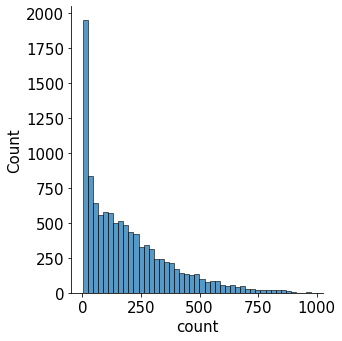

In [25]:
mpl.rc('font', size=15)  # 폰트 크기를 15로 설정
sns.displot(train_tmp['count']);  # 분포도 출력

- 타깃값인 count는 정규분포를 따르지 않음
- 회귀모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 함

데이터 분포를 정규분포 가깝게 만드는 방법 : 로그변환

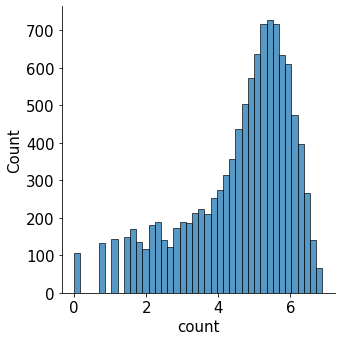

In [26]:
sns.displot(np.log(train_tmp['count']));

타깃값 count -> log(count) 변환 필요

마지막에는 지수변환하여 count로 복원

log(y) -> y

$
y = e^{log(y)}
$

------------

막대그래프

- 각 범주형 데이터에 따라 평균 대여 수량이 어떻게 다른지 파악할 때

스텝1 : m행 n열 Figure 준비하기

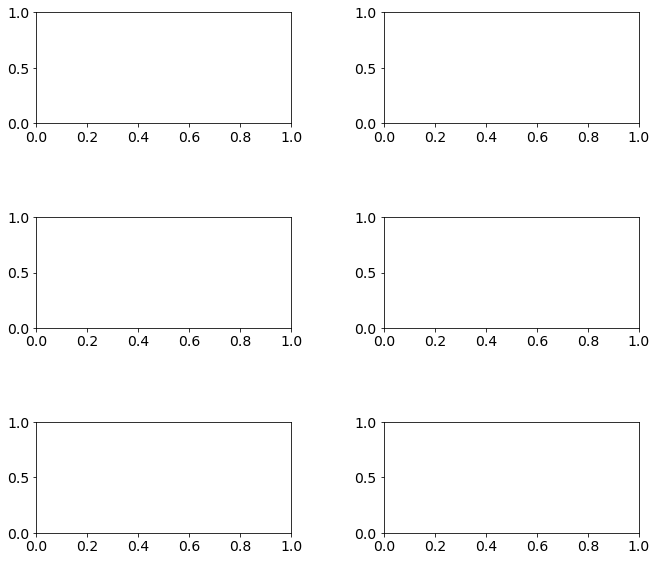

In [27]:
# 총 6게 subplot (3행 2열) Figure

mpl.rc('font', size=14)  # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2)  # 3행 2열 Figure 생성
plt.tight_layout()  # 그래프 사이에 여백 확보
figure.set_size_inches(10,9)  # 전체 Figure 크기를 10x9인치로 설정 (너비 x 높이)

스텝2 : 각 축에 서브플롯 할당

In [28]:
# 각 축에 연도, 월, 일, 시간, 분 , 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train_tmp, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train_tmp, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train_tmp, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train_tmp, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train_tmp, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train_tmp, ax=axes[2,1])

<AxesSubplot:xlabel='second', ylabel='count'>

스텝3 : (선택) 세부 설정

In [29]:
# 3-1 서브플롯에 제목 달기
axes[0,0].set(title='Rental amounts by year')
axes[0,1].set(title='Rental amounts by month')
axes[1,0].set(title='Rental amounts by day')
axes[1,1].set(title='Rental amounts by hour')
axes[2,0].set(title='Rental amounts by minute')
axes[2,1].set(title='Rental amounts by second')

[Text(0.5, 1.0, 'Rental amounts by second')]

In [30]:
# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)

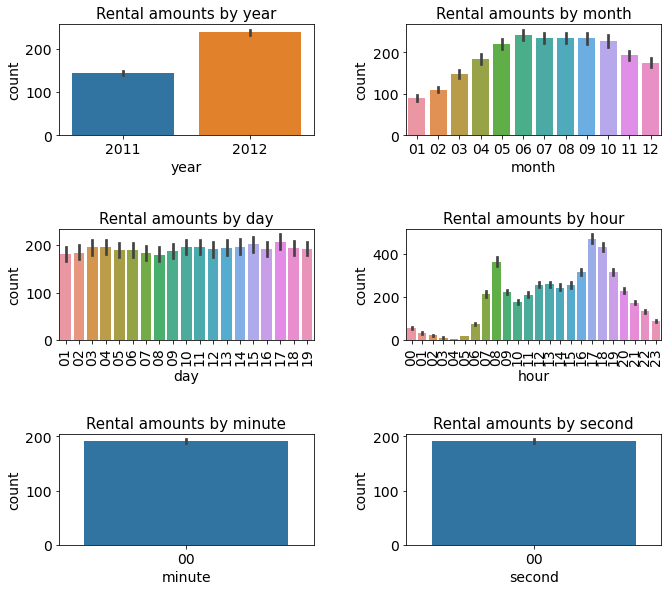

In [31]:
# 전체 코드
# 스텝1 : m행 n열 Figure 준비
# 총 6게 subplot (3행 2열) Figure

mpl.rc('font', size=14)  # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2)  # 3행 2열 Figure 생성
plt.tight_layout()  # 그래프 사이에 여백 확보
figure.set_size_inches(10,9)  # 전체 Figure 크기를 10x9인치로 설정 (너비 x 높이)

# 스텝2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분 , 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train_tmp, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train_tmp, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train_tmp, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train_tmp, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train_tmp, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train_tmp, ax=axes[2,1])

# 스텝3 : 세부 설정
## 3-1 서브플롯에 제목 달기
axes[0,0].set(title='Rental amounts by year')
axes[0,1].set(title='Rental amounts by month')
axes[1,0].set(title='Rental amounts by day')
axes[1,1].set(title='Rental amounts by hour')
axes[2,0].set(title='Rental amounts by minute')
axes[2,1].set(title='Rental amounts by second')

## 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)

In [32]:
# test.datetime.tail(30)

1. year (연도별 평균 대여 수량) - 2011년 보다 2012년에 대여가 많음
2. month (월별 평균 대여 수량) - 6월에 가장 많고 1월에 가장 적음. 날씨가 따뜻할 때 대여가 많음
3. day (일별 평균 대여 수량) - train_tmp 데이터에는 1~19일까지만 있음. test 데이터에 20일부터 월말까지
-> test와 train_tmp 공통된 값이 없으므로 day 피처 제거

4. hour (시간별 평균 대여 수량) - 아침 8시, 저녁 5~6시 출퇴근길에 많고, 새벽에는 적음
5. minute, second는 아무 정보 없음
-> minute, second 피처 제거

--------

박스플롯

- 범주형 데이터에 따른 수치형 데이터 정보를 나타내는 그래프
- 각 범주형 데이터에 따라 타깃값인 대여 수량이 어떻게 변하는지 알 수 있음

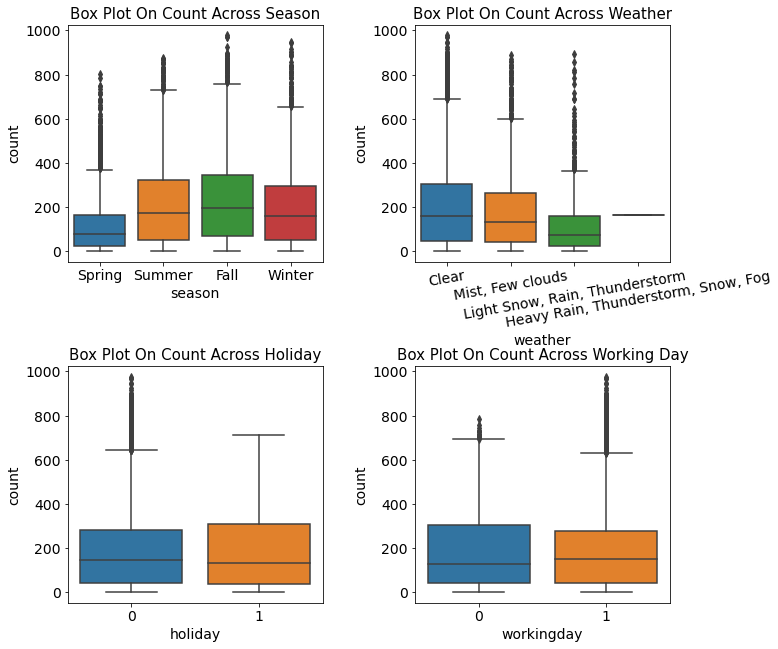

In [33]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2)  # 2행, 2열
plt.tight_layout()
figure.set_size_inches(10,10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train_tmp, ax=axes[0,0])
sns.boxplot(x='weather', y='count', data=train_tmp, ax=axes[0,1])
sns.boxplot(x='holiday', y='count', data=train_tmp, ax=axes[1,0])
sns.boxplot(x='workingday', y='count', data=train_tmp, ax=axes[1,1])

# 스텝 3: 세부 설정
## 3-1 : 서브플롯에 제목 달기
axes[0,0].set(title='Box Plot On Count Across Season')
axes[0,1].set(title='Box Plot On Count Across Weather')
axes[1,0].set(title='Box Plot On Count Across Holiday')
axes[1,1].set(title='Box Plot On Count Across Working Day')

## 3-2 : x축 라벨 겹침 해결
axes[0,1].tick_params(axis='x', labelrotation=10)  # 10도 회전

1. season (계절별 대여 수량) - 가을 > 여름 > 겨울 > 봄
2. weather (날씨별 대여 수량) - 맑은 날일 수록 대여량 많음
3. holiday (공휴일 여부에 따른 대여 수량) - 공휴일일 때와 아닐 때 차이 거의 없음
-> 공휴일 아닐 때 이상치 많음

4. workingday (근무일 여부에 따른 대여 수량) - 근무일일 때와 아닐 때 중앙 값 거의 차이는 없음
-> 근무일일 때 이상치 많음

-------

포인트플롯

- 범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시
- 막대그래프와 동일한 정보 제공

<AxesSubplot:xlabel='hour', ylabel='count'>

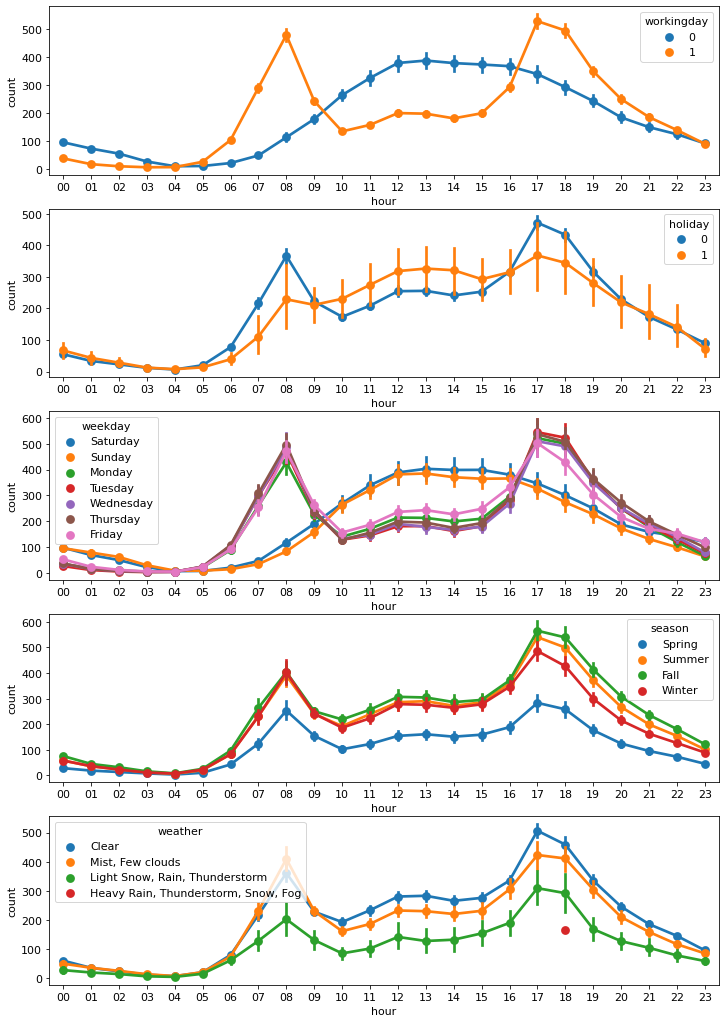

In [34]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5)  # 5행 1열
figure.set_size_inches(12,18)

# 스텝 2 : 서브플롯 할당
## 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트 플롯
sns.pointplot(x='hour', y='count', data=train_tmp, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train_tmp, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train_tmp, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train_tmp, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train_tmp, hue='weather', ax=axes[4])

1. workingday (근무일 여부에 따른 시간대별 대여 수량) - 근무일일 때는 출퇴근 시간에 많고, 쉬는 날에는 오후 12~2시에 가장 많음
2. holiday (공휴일 여부에 따른 시간대별 대여 수량)
3. weekday (요일에 따른 시간대별 대여 수량)
도 같음

4. season (계절에 따른 시간대별 대여 수량) - 가을 > 여름 > 겨울 > 봄. 역시 출퇴근 시간에 많음
5. weather (날씨에 따른 시간대별 대여 수량) - 날씨가 좋을 수록 대여량이 많음
-> weather 4(= Heavy Rain) -> 18시에 대여 건수 하나 있음
-> weather == 4 데이터 제거?

--------

회귀선을 포함한 산점도 그래프

- 수치형 데이터 간 상관관계 파악하는 데 사용

<AxesSubplot:xlabel='humidity', ylabel='count'>

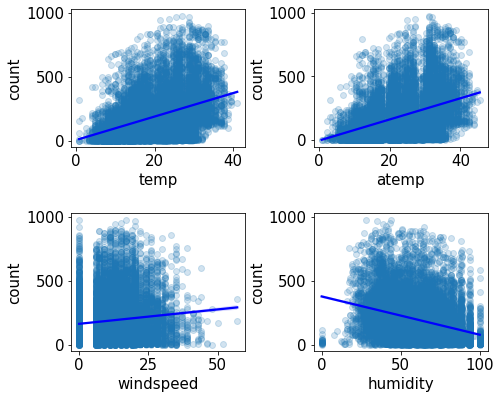

In [35]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2)  # 2행 2열
plt.tight_layout()
figure.set_size_inches(7,6)

# 스텝 2 : 서브플롯 할당
## 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train_tmp, ax=axes[0,0],
           scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='atemp', y='count', data=train_tmp, ax=axes[0,1],
           scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='windspeed', y='count', data=train_tmp, ax=axes[1,0],
           scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='humidity', y='count', data=train_tmp, ax=axes[1,1],
           scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})

1. temp (온도별 대여 수량) - 온도가 높을 수록 대여 수량이 많음
2. atemp (체감 온도별 대여 수량) - 체감 온도가 높을 수록 대여 수량 많음
4. humidity (습도별 대여 수량) - 습할 수록 대여 수량 적음
//
3. windspeed (풍속별 대여 수량) - 회귀선을 보면 풍속이 셀수록 대여 수량이 많음
-> 바람이 약할수록 많을 것 같은데 이상

-> windspeed에 결측값 존재

-----

히트맵

- 수치형 데이터끼리 어떤 상관관계가 있는지 알아볼 때
- corr() 상관관계

In [36]:
train_tmp[['temp','atemp','humidity','windspeed','count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


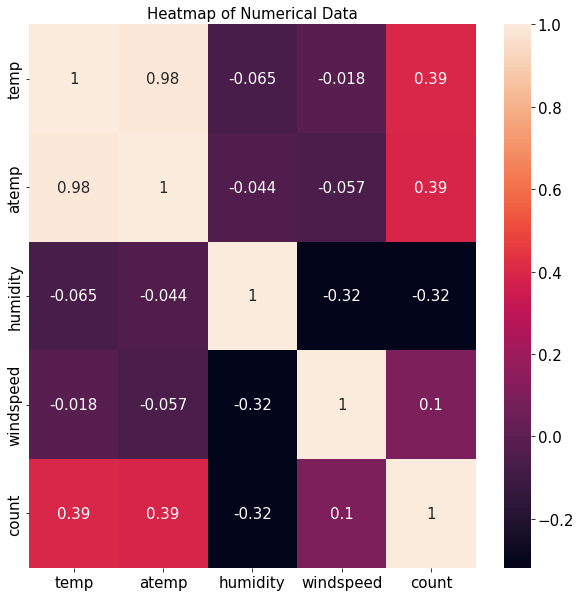

In [37]:
# 피처 간 상관관계 매트릭스
corrMat = train_tmp[['temp','atemp','humidity','windspeed','count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMat, annot=True)  # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

- 타깃값인 count와의 상관관계가 중요
1. 온도와 count 간 상관계수 0.39 >> 양의 상관관계 >> 온도가 높을수록 대여 수량이 많음
2. 습도와 count 간 상관계수 -0.32 >> 음의 상관관계 >> 습도가 낮을수록 대여 수량이 많음

3. 풍속과 count 간 상관계수 0.1 >> 상관관계 약함
-> windspeed 피처는 대여 수량 예측에 도움을 주지 못함

-> 성능을 높이기 위해서는 windspeed 제거

------

정리
1. 타깃값 변환 - count -> log(count) / 마지막에 log(count) -> count
2. test에는 없는 train column - casual, registered 피처 제거
3. datetime은 인덱스 역할 >> 타깃값 예측 도움 X >> 제거
4. date -> year, month, day로 분리했으므로 >> date 피처 제거
5. month -> 3달씩 묶으면 = season >> month 피처 제거
6. test와 train 공통된 값이 없으므로 day 피처 제거
7. minute, second 피처 제거
8. 공휴일 아닐 때 이상치 많음
9. 근무일일 때 이상치 많음
10. weather == 4 데이터 제거?
11. windspeed에 결측값 존재

-------

## 베이스라인 모델

### 피처 엔지니어링

이상치 제거

In [38]:
train[train['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


In [39]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

데이터 합치기

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10885 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10885 non-null  object 
 1   season      10885 non-null  int64  
 2   holiday     10885 non-null  int64  
 3   workingday  10885 non-null  int64  
 4   weather     10885 non-null  int64  
 5   temp        10885 non-null  float64
 6   atemp       10885 non-null  float64
 7   humidity    10885 non-null  int64  
 8   windspeed   10885 non-null  float64
 9   casual      10885 non-null  int64  
 10  registered  10885 non-null  int64  
 11  count       10885 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


In [41]:
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [42]:
all_data_temp = pd.concat([train, test])
all_data_temp
# datetime기준으로 아래로 붙임 (default : axis = 0)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


17378 rows 인데 6492행까지밖에 안나옴

-> 원래 데이터 인덱스를 무시하고 이어붙이려면 `ignore_index=True`

In [43]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [44]:
all_data[all_data['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
11039,2011-01-26 16:00:00,1,0,1,4,9.02,9.85,93,22.0028,NaN,NaN,NaN
14133,2012-01-21 01:00:00,1,0,0,4,5.74,6.82,86,12.9980,NaN,NaN,NaN


파생 피처(변수) 추가

In [45]:
# 정리 7,8 >> day, minute, second 필요 없음
# 파생 변수 생성
all_data['date'] = all_data['datetime'].apply(lambda x : x.split()[0])  # 날짜 피처 생성

# 연도, 월, 일, 시, 분 초 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
# all_data['day'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[2])
all_data['hour'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
# all_data['minute'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[1])
# all_data['second'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[2])

In [46]:
# apply()함수로 요일(weekday) 피처 생성
all_data['weekday'] = all_data['date'].apply(
                    lambda dateString:
                    datetime.strptime(dateString, "%Y-%m-%d").weekday())

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
 12  date        17378 non-null  object 
 13  year        17378 non-null  object 
 14  month       17378 non-null  object 
 15  hour        17378 non-null  object 
 16  weekday     17378 non-null  int64  
dtypes: float64(6), int64(6), object(5)
memory usage: 2.3+ MB


필요 없는 피처 제거

In [48]:
# 정리 2 casual, registered 제거
# 정리 3 datetime
# 정리 4 date 제거
# 정리 5 month 제거
# 정리 11 windspeed 제거

In [49]:
drop_feature = ['casual','registered','datetime','date','month','windspeed']
all_data = all_data.drop(drop_feature, axis=1)

In [50]:
all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


데이터 나누기

In [51]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# all_data['count']가 null이면 test data

In [52]:
# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y_train = train['count']  # 타깃값

In [53]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10885 entries, 0 to 10884
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10885 non-null  int64  
 1   holiday     10885 non-null  int64  
 2   workingday  10885 non-null  int64  
 3   weather     10885 non-null  int64  
 4   temp        10885 non-null  float64
 5   atemp       10885 non-null  float64
 6   humidity    10885 non-null  int64  
 7   year        10885 non-null  object 
 8   hour        10885 non-null  object 
 9   weekday     10885 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 935.4+ KB


### 평가지표 계산 함수 작성

평가지표 : RMSLE

In [55]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

- `exp()` : 지수변환
- convertExp = True >>
    log(y) -> y로 지수변환할 때 사용
- `np.log()` : e
- `np.nan_to_num()` : NaN 결측값을 모두 0으로 바꾸는 기능
- `np.log(y+1)` = `np.log1p(y)`

- RMSLE
$\sqrt{\frac{1}{N}\sum_{i=1}^N(log(y_i+1)- log(\hat{y_i}+1))^2}$

### 모델 훈련

#### LinearRegression

In [56]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [57]:
log_y = np.log(y_train)  # 타깃값 로그변환
linear_reg_model.fit(X_train, log_y)  # 모델 훈련

LinearRegression()

$$ Y = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 $$
- Y : 종속변수 (타깃값)
- $\theta$ : 회귀계수 (가중치)
- x : 독립변수 (피처)

- 훈련 : 피처(독립변수)와 타깃값(종속변수)이 주어졌을 때 최적의 가중치(회귀계수)를 찾는 과정
- 예측 : 최적의 가중치를 아는 상태(훈련된 모델)에서 새로운 독립변수(데이터)가 주어졌을 때 타깃값을 추정하는 과정

#### Ridge Regression

- L2 규제를 적용한 선형 회귀 모델
- 규제(regularizaton)란 모델이 훈련 데이터에 overfitting되지 않도록 해주는 방버브

In [61]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

그리드서치 객체 생성

In [62]:
# 하이퍼파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}

# 교제 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator = ridge_model,  # 릿지 모델
                                     param_grid = ridge_params, # 값 목록
                                     scoring = rmsle_scorer,  # 평가지표
                                     cv=5)                    # 교차 검증 분할 수

```
GridSearchCV(
    estimator : 분류 및 회귀 모델
    param_grid : 딕셔너리 형태로 모델의 하이퍼파라미터명과 하이퍼파라미터 값 지정
    scoring : 평가지표
    (정확도 = 'accuracy', F1 = 'f1', ROC-AUC = 'roc_auc', 재현율 = 'recall')
    cv : 교차 검증 분할 개수(기본값 5)
```

그리드 서치 수행

In [66]:
log_y = np.log(y_train)  # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [67]:
print('최적 하이퍼파라미터 : ', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 :  {'alpha': 0.1, 'max_iter': 3000}


#### Lasso Regression

- L1 규제를 적용한 선형 회귀 모델

In [71]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4,10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator = lasso_model,
                                     param_grid = lasso_params,
                                     scoring = rmsle_scorer,
                                     cv = 5)

# 그리드서치 수행
log_y = np.log(y_train)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 : ', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 :  {'alpha': 0.00125, 'max_iter': 3000}


#### 랜덤 포레스트 회귀 모델

In [75]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                             param_grid = rf_params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
# 그리드서치 수행
log_y = np.log(y_train)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


### 모델 성능 검증

In [58]:
preds = linear_reg_model.predict(X_train)

In [59]:
print(f'선형 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형 회귀의 RMSLE 값 : 1.0205


In [68]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

In [69]:
print(f'릿지 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀의 RMSLE 값 : 1.0205


In [72]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

In [73]:
print(f'라쏘 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀의 RMSLE 값 : 1.0205


In [76]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

In [78]:
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1126


### 예측 및 결과 제출

Text(0.5, 1.0, 'Predicted Test Data Distribution')

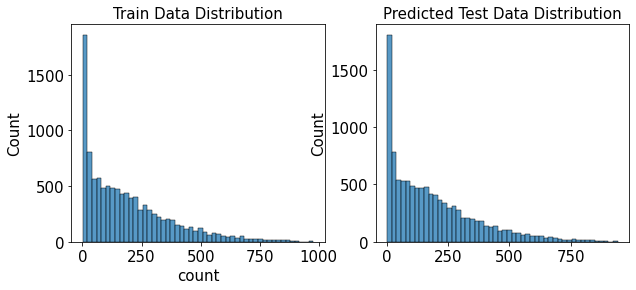

In [81]:
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

figure, axes = plt.subplots(ncols =2)
figure.set_size_inches(10,4)

sns.histplot(y_train, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution')

In [60]:
# linearreg_preds = linear_reg_model.predict(X_test)  # 테스트 데이터로 예측

# submission['count'] = np.exp(linearreg_preds) # 지수변환
# submission.to_csv('submission.csv', index=False) # 파일로 저장